# Carga das Bibliotecas e Recuperação dos Dados

In [1]:
import re
import json
import requests
import numpy as np
import pandas as pd
from math import ceil
import seaborn as sns
from io import BytesIO
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score

In [2]:
response = requests.get("https://raw.githubusercontent.com/kalingth/heart-disease-classifier/main/heart.csv")
response.raise_for_status()
_file = BytesIO(response.content)
dataset = pd.read_csv(_file)

duplicateds = dataset.duplicated().sum()
print(f"Número de linhas duplicadas: {duplicateds}")
if duplicateds / len(dataset) > .1:
    dataset.drop_duplicates(inplace=True)

nulls = ", ".join(f"{key}={value}" for key, value in dataset.isna().sum().items())
print(f"Dados Nulos: {nulls}", "-" * 80, sep="\n")
dataset.describe()

Número de linhas duplicadas: 1
Dados Nulos: age=0, sex=0, cp=0, trtbps=0, chol=0, fbs=0, restecg=0, thalachh=0, exng=0, oldpeak=0, slp=0, caa=0, thall=0, output=0
--------------------------------------------------------------------------------


age         sex          cp      trtbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg    thalachh        exng     oldpeak         slp         caa  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.905161    0.469794    1.161075    0.616226    1.022606   
min      0.000000   71.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000  133.500000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    1.000000    0.000000   
75%      1.000000  166.000000    1.000000    1.600000    2.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    2.000000    4.000000   

            thall      output  
count  303.000000  303.000000  
mean     2.313531    0.544554  
std      0.612277    0.498835  
min      0.000000    0.000000  
25%      2.000000    0.000000  
50%      2.000000    1.000000  
75%      3.000000    1.000000  
max      3.000000    1.000000

In [3]:
SEED = 42
_labels = {
    "age": "Age", # Idade do Paciente - Variável Discreta - range da amostra: 29 a 77 anos
    "sex": "Sex", # Sexo do Paciente - Variável Categórica - que indica o sexo biológico do paciente
    "cp": "Chest Pain Type", # Tipo de Dor no Peito - Variável Categórica - range de valores: 0 a 3
    "trtbps": "Resting Blood Pressure", # Pressão Arterial em Repouso - Variável Contínua - range de valores: 94 a 200
    "chol": "Cholesterol Level", # Nível de Colesterol - Variável Contínua - range de valores: 126 a 564
    "fbs": "Fasting Blood Sugar", # Açúcar no Sangue em Jejum - Variável Categórica - Verdadeiro caso FBS > 120 mg/dl
    "restecg": "Resting Electrocardiographic Results", # Resultados do Eletrocardiograma em Repouso - Variável Categórica - 0 para
    "thalachh": "Maximum Heart Rate Achieved", # Frequência Cardíaca Máxima Alcançada
    "exng": "Exercise Induced Angina", # Angina Induzida por Exercícios - Variável Categórica
    "oldpeak": "ST Depression Induced by Exercise Relative to Rest", # Depressão do Segmento ST Induzida pelo Exercício em Relação ao Repouso
    "slp": "Slope of the ST Segment at Peak Exercise", # Inclinação do Segmento ST no Pico do Exercício
    "caa": "Number of Major Vessels Colored by Fluoroscopy", # Número de Vasos Principais Coloridos por Fluoroscopia
    "thall": "Thalassemia", # Talassemia - um tipo de anemia hereditária
    "output": "Results", # Variável Categórica Utilizada para Classificação - 0 para não e 1 para sim
}

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


# Funções

In [4]:
def one_hot_encode_wo_dummies(dataset, target):
    # type: (pd.Dataframe, str) -> None
    """Realiza o One-Hot Encoding em atributos categóricos numéricos e remove a coluna original.

    Parâmetros:
        dataset (pd.DataFrame): O DataFrame contendo os dados.
        target (str): O nome da coluna categórica numérica a ser transformada.

    Retorno:
        pd.DataFrame: O DataFrame após a aplicação do One-Hot Encoding.
    """
    global _labels
    uniques = dataset[target].unique()
    tam = len(uniques)# - 1
    for i in range(1, tam):
        new_label = f"{target}_type{i}"
        _labels[new_label] = f"{_labels[target]} - Type {i}"
        dataset.insert(0, new_label, (dataset[target] == uniques[i]).astype(np.integer))
    dataset.pop(target)

In [5]:
def plot_corr_heatmap(dataset):
    # type: (pd.Dataframe) -> None
    columns = dataset.shape[1]
    mask = np.array([[y >= x for y in range(columns)] for x in range(columns)])
    plt.figure(figsize=(8,6))
    sns.heatmap(dataset.corr(), cmap="seismic", mask=mask, vmax=1, vmin=-1, annot=True, fmt=".0%", annot_kws = {'size' : 7})
    plt.show()

In [6]:
def trend_line(x, y):
    treined = np.polyfit(x, y, 1)
    poly = np.poly1d(treined)
    out_x = [min(x), max(x)]
    return [out_x, poly(out_x), f"{poly.coeffs[0]:.5f}x + ({poly.coeffs[1]:.5f})"]

In [7]:
def cross_val_score(model, X, y, label):
    # type: (BaseEstimator, pd.Dataframe, pd.Dataframe, str) -> None
    global SEED
    splits = 5
    cv = KFold(n_splits=splits, random_state=SEED, shuffle=True)


    train_recall, val_recall = [], []
    train_precision, val_precision = [], []
    train_accuracy, val_accuracy = [], []


    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):


        model.fit(X.iloc[train_idx], y.iloc[train_idx])


        train_preds = model.predict(X.iloc[train_idx])
        val_preds = model.predict(X.iloc[val_idx])


        train_recall.append(recall_score(y.iloc[train_idx], train_preds))
        val_recall.append(recall_score(y.iloc[val_idx], val_preds))


        train_precision.append(precision_score(y.iloc[train_idx], train_preds))
        val_precision.append(precision_score(y.iloc[val_idx], val_preds))


        train_accuracy.append(accuracy_score(y.iloc[train_idx], train_preds))
        val_accuracy.append(accuracy_score(y.iloc[val_idx], val_preds))


    mean_test_prec, std_test_prec = np.mean(val_precision), np.std(val_precision)
    mean_test_recall, std_test_recall = np.mean(val_recall), np.std(val_recall)
    mean_test_acc, std_test_acc = np.mean(val_accuracy), np.std(val_accuracy)


    mean_train_prec, std_train_prec = np.mean(train_precision),np.std(train_precision)
    mean_train_recall, std_train_recall = np.mean(train_recall), np.std(train_recall)
    mean_train_acc, std_train_acc = np.mean(train_accuracy), np.std(train_accuracy)


    print(
        f'{label} - '
        f'Test Precision: {mean_test_prec:.2%} ± {std_test_prec:.2%} | '
        f'Test Recall: {mean_test_recall:.2%} ± {std_test_recall:.2%} | '
        f'Test Accuracy: {mean_test_acc:.2%} ± {std_test_acc:.2%} | '
        f'Train Precision: {mean_train_prec:.2%} ± {std_train_prec:.2%} | '
        f'Train Recall: {mean_train_recall:.2%} ± {std_train_recall:.2%} | '
        f'Train Accuracy: {mean_train_acc:.2%} ± {std_train_acc:.2%}'
    )


    tests_precision_results = ", ".join(f"{n:.2%}" for n in val_precision)
    tests_recall_results = ", ".join(f"{n:.2%}" for n in val_recall)
    tests_accuracy_results = ", ".join(f"{n:.2%}" for n in val_accuracy)
    print(f"{label} - Tests Precision Results:", tests_precision_results)
    print(f"{label} - Tests Recall Results:", tests_recall_results)
    print(f"{label} - Tests Accuracy Results:", tests_accuracy_results)

In [36]:
def plot_decision(model, row):
    global _labels
    _size = model.tree_.n_leaves * 2, model.tree_.max_depth * 8 - 19

    sub_pattern = r"\nsamples.+|\nvalue.+|\ngini.+|\nentropy.+|\nlog_loss.+"

    path = model.decision_path(row)
    plt.figure(figsize=_size)
    predicted = model.predict(row)[0]
    colors = {0: "lightgreen", 1: "lightcoral"}
    plot_parameters = {
        "feature_names": row.columns,
        "class_names": ["Saudável", "Doente"],
        "node_ids": True,
    }

    tree = plot_tree(model, **plot_parameters)
    for _index, _box in enumerate(tree):
        old_text = _box.get_text()
        new_text = re.sub(sub_pattern, "", old_text)
        _box.set_text(new_text)
        if _index in path.indices:
            _class_name = re.sub(r"^(\S+).+", r"\1", old_text.split("\n")[1])
            _val = row.get(_class_name)
            if _val is not None:
                new_text += f"\n{_class_name} = {_val.values[0]}"

            bbox = _box.get_bbox_patch()
            bbox.set_facecolor(colors[predicted])
            _box.set_fontsize(model.tree_.n_leaves)

            label_name = _labels.get(_class_name, _class_name)
            _box.set_text(new_text.replace(_class_name, label_name))
            _box.set_zorder(1000 - _index)
        else:
            _box.set_alpha(.3)

    plt.show()

In [9]:
def _print_row(vt_model, row, target):
    print("Dados de Entrada:", json.dumps({key: value for key, value in zip(row_analysis.columns, *row_analysis.values)}))
    classifications = {}
    for _index, model in enumerate(vt_classifier.estimators_):
        predicted = model.predict(row)[0]
        print(f"Modelo {_index}:", predicted)
        classifications[predicted] = classifications.get(predicted, 0) + 1

    print("Resultado das Validações:", classifications)
    print("Valor Final Predito:", vt_model.predict(row)[0])
    print("Valor Real:", target.values[0])
    print("-" * 60, "\n")

# Análise dos Dados

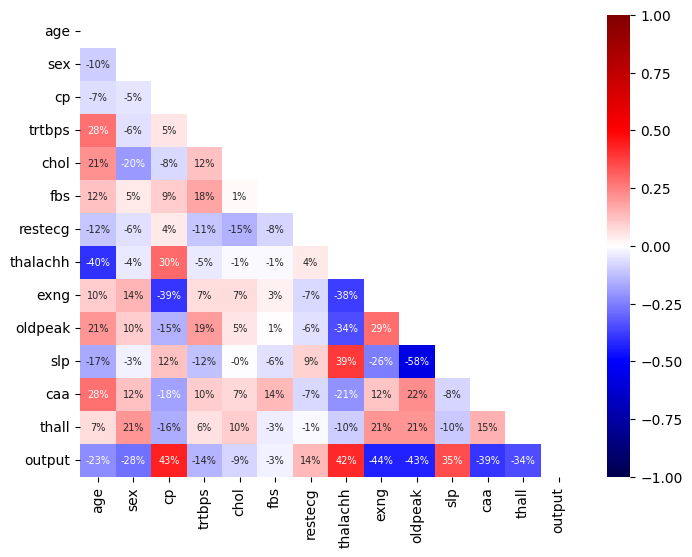

In [10]:
# Análise da Correlação entre as Variáveis
plot_corr_heatmap(dataset)

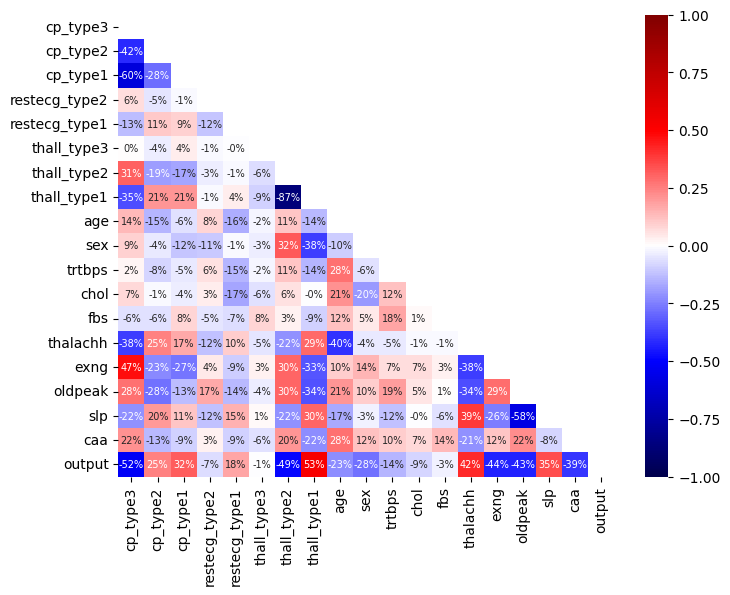

In [11]:
# A variável thalassemia é uma variável categórica!
# Portanto, para que uma classe não seja identificada como um peso, seus dados serão desmembrados
one_hot_encode_wo_dummies(dataset, "thall")

# A variável RESTECG é uma variável categórica!
# Portanto, para que o atributo não seja identificada como um peso, seus dados serão desmembrados
one_hot_encode_wo_dummies(dataset, "restecg")

# A variável CP é uma variável categórica!
# Portanto, para que o atributo não seja identificada como um peso, seus dados serão desmembrados
one_hot_encode_wo_dummies(dataset, "cp")

# Nova Análise da Correlação entre as Variáveis
plot_corr_heatmap(dataset)

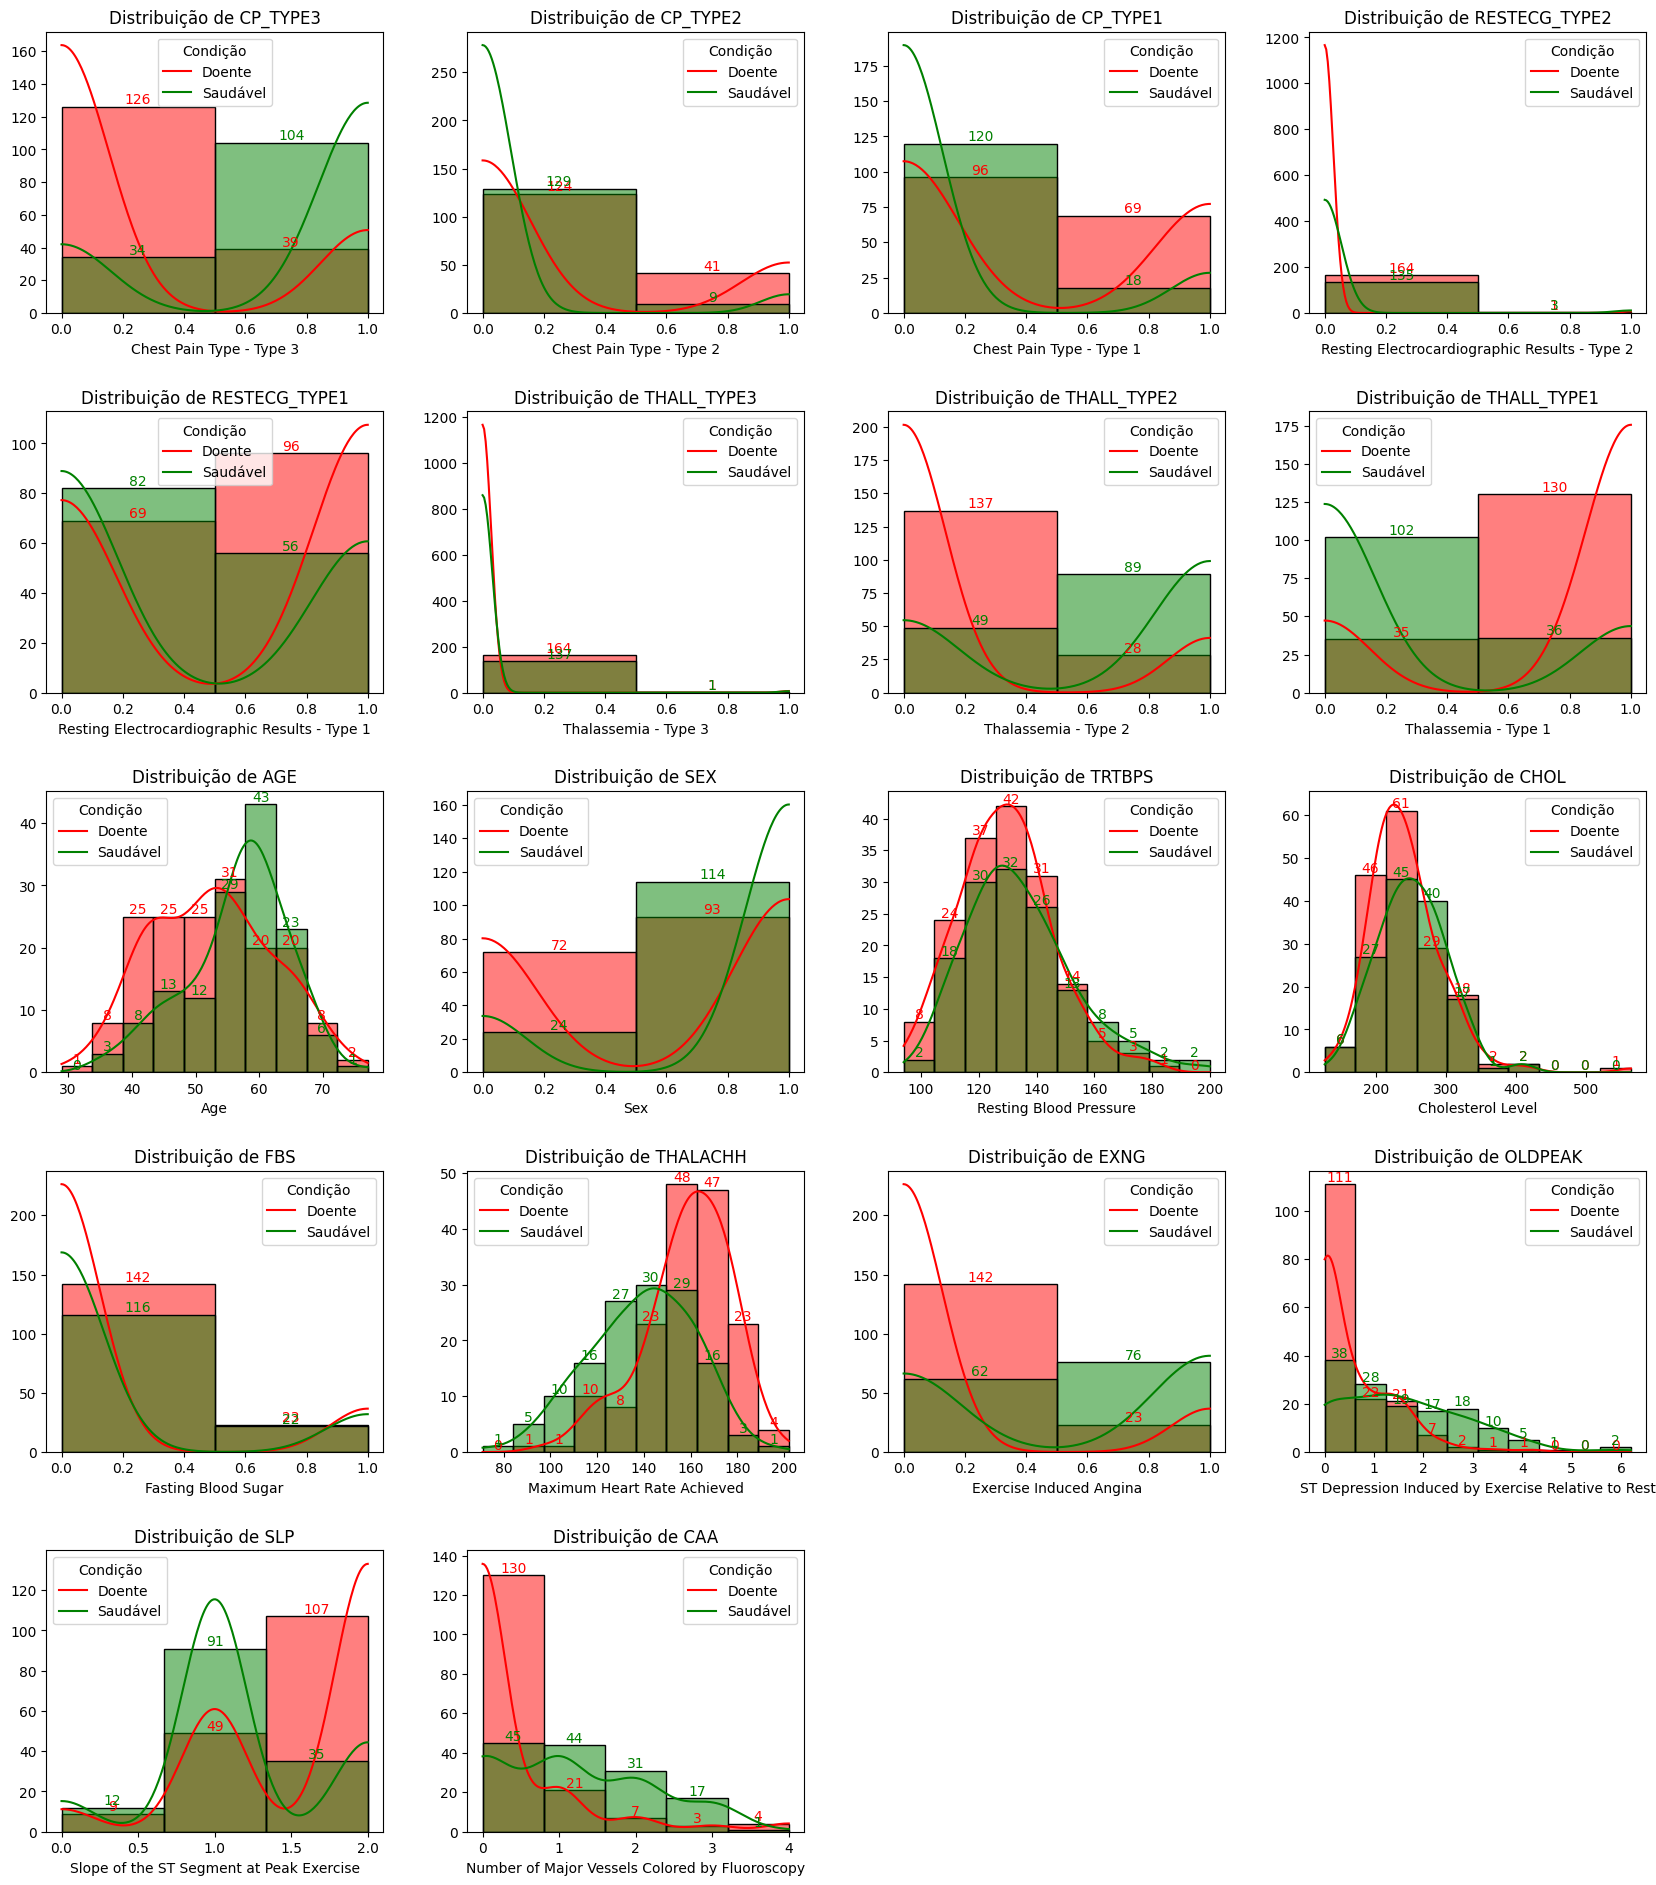

In [12]:
# Análise da Distribuição das Variáveis
wo_output = dataset.drop("output", axis=True).keys()
_columns = 4
_rows = ceil(len(wo_output) / _columns)
figsize = _columns * 8, len(wo_output) * 2

fig, axs = plt.subplots(nrows=_rows, ncols=_columns, figsize=figsize)
plt.subplots_adjust(left=0, bottom=0, right=.5, top=.5, wspace=.25, hspace=.35)
palette ={0: "green", 1: "red"}

for _index, _column_name in enumerate(wo_output):
    _column, _row = _index % _columns, _index // _columns
    _unique_count = len(dataset[_column_name].unique())
    _bins = min(_unique_count, 10)

    _axs = sns.histplot(dataset, x=_column_name, hue="output", kde=True, ax=axs[_row, _column], bins=_bins, palette=palette)
    _axs.bar_label(_axs.containers[0], color="red")
    _axs.bar_label(_axs.containers[1], color="green")

    axs[_row, _column].set_title(f"Distribuição de {_column_name.upper()}")
    axs[_row, _column].set_xlabel(_labels.get(_column_name, _column_name))
    axs[_row, _column].set_ylabel("")
    axs[_row, _column].legend(title="Condição", labels=["Doente", "Saudável"])

axs[-1, -2].set_visible(False)
axs[-1, -1].set_visible(False)

plt.show()

In [13]:
# Separação das Variáveis Com Correlação Maior que 40% com a Variável Objetivo
corr = dataset.corr()
better_corrs = abs(corr["output"]) > .4
better_corrs_names = list(corr[better_corrs].index)
better_corrs_names.remove("output")
combined_corr = [*combinations(better_corrs_names, 2)]

_sick = dataset[dataset["output"] == 1]
_healthy = dataset[dataset["output"] == 0]

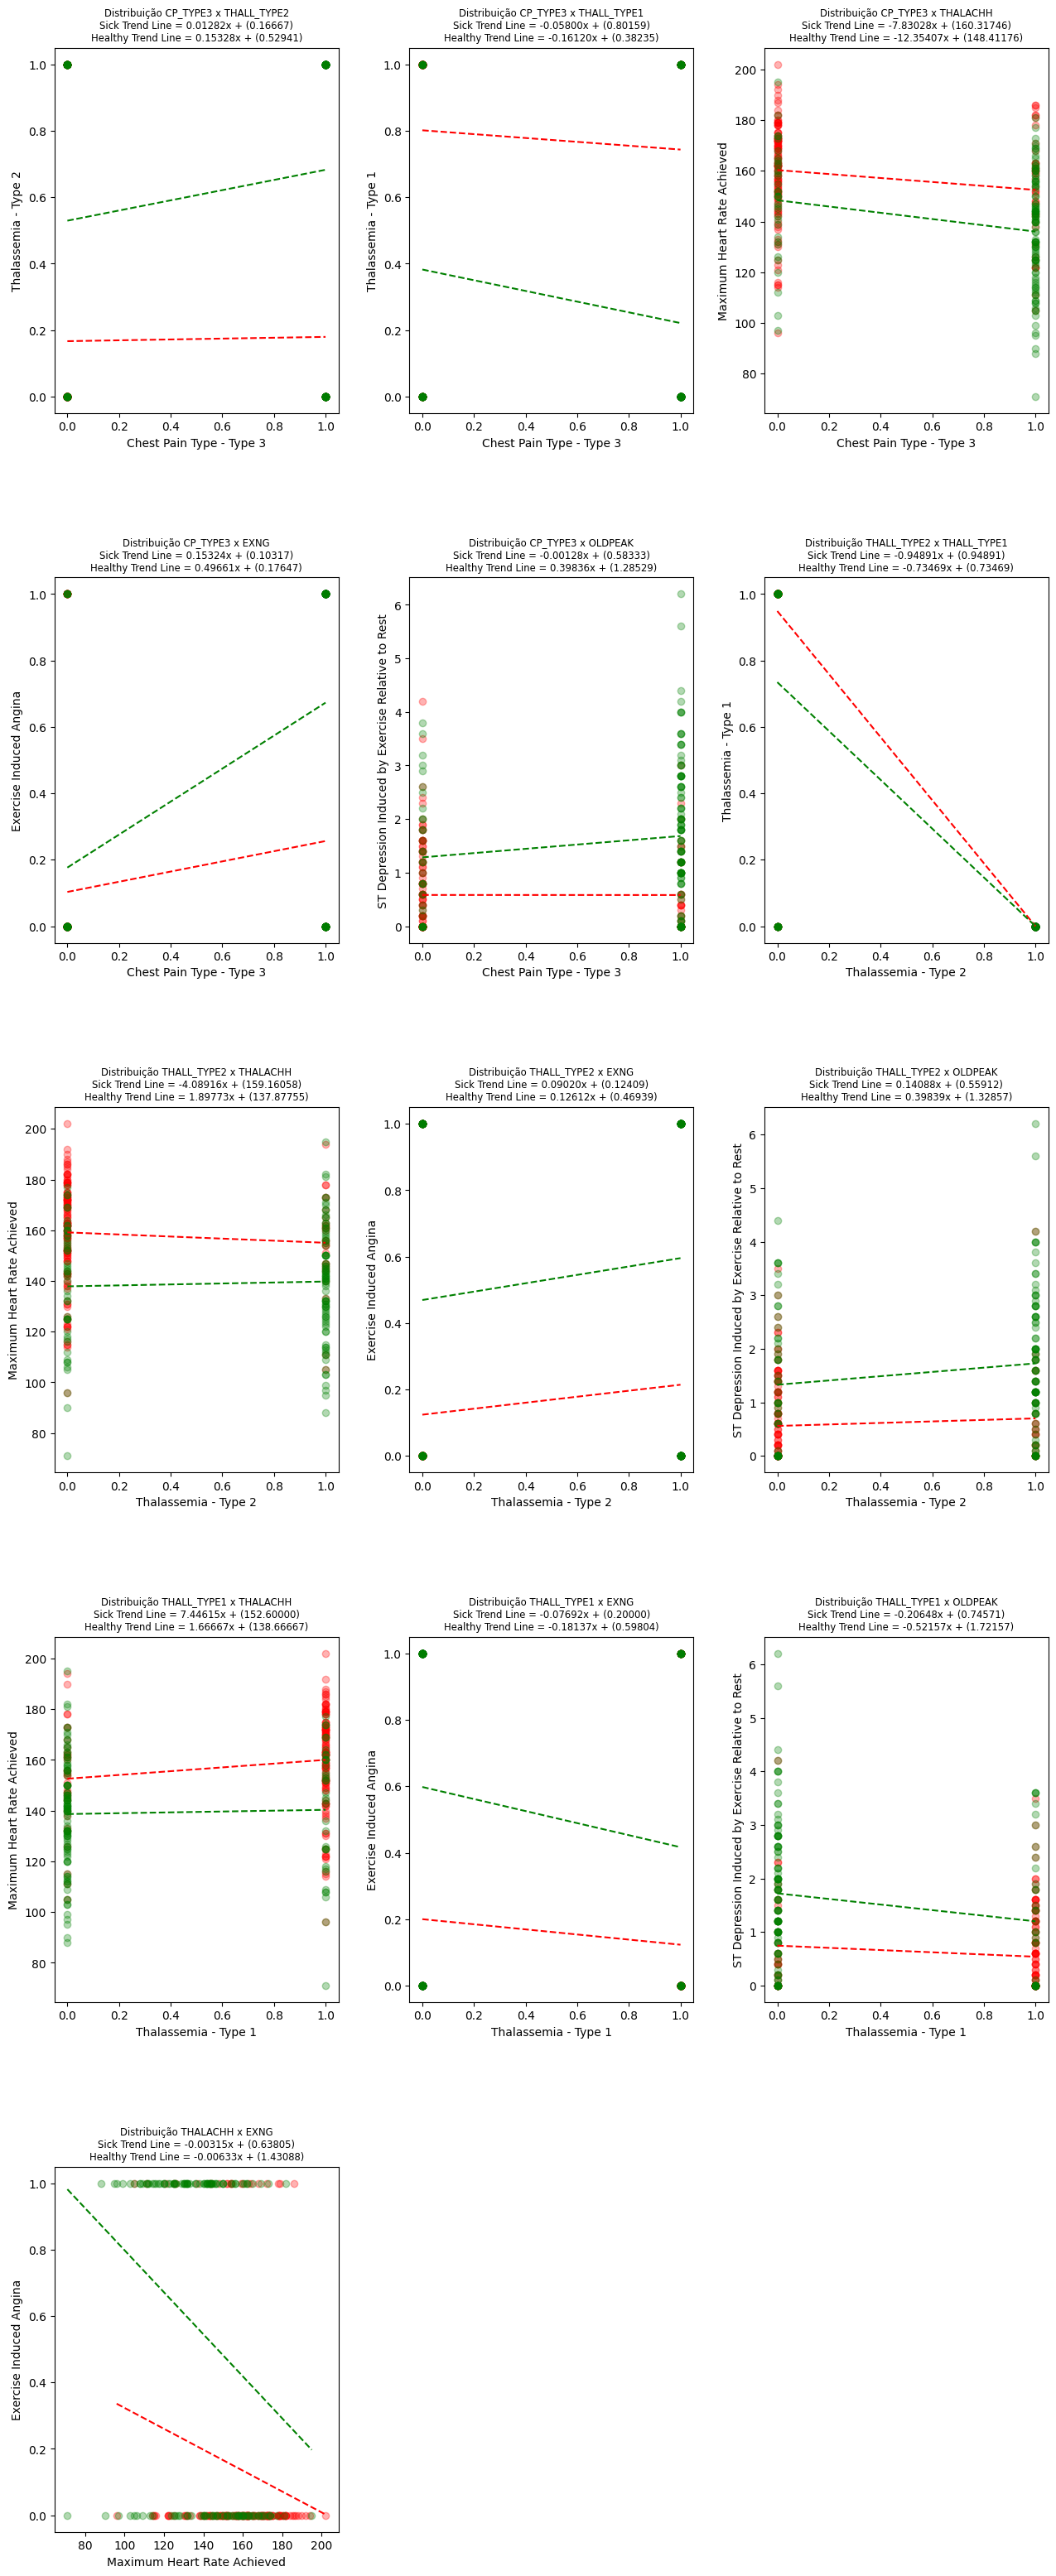

In [14]:
# Análise da Distribuição das Principais Variáveis com a Variável Objetivo
_columns = 3
_rows = ceil(len(combined_corr) / _columns)
figsize = _columns * 4, len(combined_corr) * 2

fig, axs = plt.subplots(nrows=_rows, ncols=_columns, figsize=figsize)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=.25, hspace=.45)
plt.rc('font', size=7)

for _index, (x, y) in enumerate(combined_corr):
    _column, _row = _index % _columns, _index // _columns

    axs[_row, _column].scatter(_sick[x], _sick[y], c='red', alpha=.3)
    trend_sick = trend_line(_sick[x], _sick[y])
    sick_formula = trend_sick.pop()
    axs[_row, _column].plot(*trend_sick, c='red', linestyle="--")

    axs[_row, _column].scatter(_healthy[x], _healthy[y], c='green', alpha=.3)
    trend_healthy = trend_line(_healthy[x], _healthy[y])
    healthy_formula = trend_healthy.pop()
    axs[_row, _column].plot(*trend_healthy, c='green', linestyle="--")

    axs[_row, _column].set_xlabel(_labels.get(x, x))
    axs[_row, _column].set_ylabel(_labels.get(y, y))
    axs[_row, _column].set_title(f"Distribuição {x.upper()} x {y.upper()}\nSick Trend Line = {sick_formula}\nHealthy Trend Line = {healthy_formula}")

axs[-1, -2].set_visible(False)
axs[-1, -1].set_visible(False)

plt.show()

# Treinamento dos Modelos

In [15]:
# Separação das Variáveis
X = dataset.drop("output", axis=True)
y = dataset["output"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=SEED)

In [16]:
# Treinamento dos Modelos que Realizarão a Predição
trees = [
    ("1º_DecisionTree", DecisionTreeClassifier(random_state=SEED)),
    ("2º_DecisionTree", DecisionTreeClassifier(criterion="entropy", random_state=SEED)),
    ("3º_DecisionTree", DecisionTreeClassifier(criterion="log_loss", max_depth=6, min_samples_leaf=3, random_state=SEED)),
    ("4º_DecisionTree", DecisionTreeClassifier(min_samples_split=20, min_samples_leaf=7, random_state=SEED)),
    ("5º_DecisionTree", DecisionTreeClassifier(min_samples_split=15, min_samples_leaf=15, random_state=SEED)),
    ("6º_DecisionTree", DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_leaf=15, random_state=SEED)),
    ("7º_DecisionTree", DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_leaf=10, random_state=SEED)),
]

for pos, (name, tree) in enumerate(trees):
    cross_val_score(tree, X, y, name)
    print("-"* 75, "\n")

1º_DecisionTree - Test Precision: 80.34% ± 5.78% | Test Recall: 83.91% ± 4.09% | Test Accuracy: 79.53% ± 4.54% | Train Precision: 100.00% ± 0.00% | Train Recall: 100.00% ± 0.00% | Train Accuracy: 100.00% ± 0.00%
1º_DecisionTree - Tests Precision Results: 87.10%, 82.86%, 77.14%, 70.73%, 83.87%
1º_DecisionTree - Tests Recall Results: 84.38%, 76.32%, 87.10%, 87.88%, 83.87%
1º_DecisionTree - Tests Accuracy Results: 85.25%, 75.41%, 80.33%, 73.33%, 83.33%
--------------------------------------------------------------------------- 

2º_DecisionTree - Test Precision: 79.22% ± 6.12% | Test Recall: 80.08% ± 4.92% | Test Accuracy: 77.22% ± 3.90% | Train Precision: 100.00% ± 0.00% | Train Recall: 100.00% ± 0.00% | Train Accuracy: 100.00% ± 0.00%
2º_DecisionTree - Tests Precision Results: 85.19%, 83.33%, 75.00%, 69.23%, 83.33%
2º_DecisionTree - Tests Recall Results: 71.88%, 78.95%, 87.10%, 81.82%, 80.65%
2º_DecisionTree - Tests Accuracy Results: 78.69%, 77.05%, 78.69%, 70.00%, 81.67%
--------------

In [17]:
# Validação do Modelo de Classificação Centralizado
vt_classifier = VotingClassifier(trees)
cross_val_score(vt_classifier, X, y, "Comitê Decisório")

Comitê Decisório - Test Precision: 81.96% ± 6.78% | Test Recall: 87.48% ± 3.31% | Test Accuracy: 82.18% ± 5.16% | Train Precision: 88.45% ± 2.04% | Train Recall: 92.61% ± 2.70% | Train Accuracy: 89.35% ± 2.53%
Comitê Decisório - Tests Precision Results: 90.32%, 83.78%, 75.00%, 73.17%, 87.50%
Comitê Decisório - Tests Recall Results: 87.50%, 81.58%, 87.10%, 90.91%, 90.32%
Comitê Decisório - Tests Accuracy Results: 88.52%, 78.69%, 78.69%, 76.67%, 88.33%


In [18]:
# Análise dos Resultados do Modelo
vt_classifier.fit(X_train, y_train)
preds = vt_classifier.predict(X_test)

headers = [["TP", "FP"], ["FN", "TN"]]
(TP, FP), (FN, TN) = confusion_matrix(y_test, preds)
print(f"{TP=}\t{FP=}\n{FN=}\t{TN=}", "-" * 80, sep="\n")
print(classification_report(y_test, preds))

TP=26	FP=3
FN=4	TN=28
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.88      0.89        32

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



In [38]:
_index = 71
row_analysis = X[_index:_index+1]

vt_classifier.predict(row_analysis)

array([1])

Dados de Entrada: {"cp_type3": 0.0, "cp_type2": 0.0, "cp_type1": 1.0, "restecg_type2": 0.0, "restecg_type1": 1.0, "thall_type3": 0.0, "thall_type2": 1.0, "thall_type1": 0.0, "age": 51.0, "sex": 1.0, "trtbps": 94.0, "chol": 227.0, "fbs": 0.0, "thalachh": 154.0, "exng": 1.0, "oldpeak": 0.0, "slp": 2.0, "caa": 1.0}
Modelo 0: 1
Modelo 1: 1
Modelo 2: 1
Modelo 3: 1
Modelo 4: 0
Modelo 5: 0
Modelo 6: 0
Resultado das Validações: {1: 4, 0: 3}
Valor Final Predito: 1
Valor Real: 1
------------------------------------------------------------ 



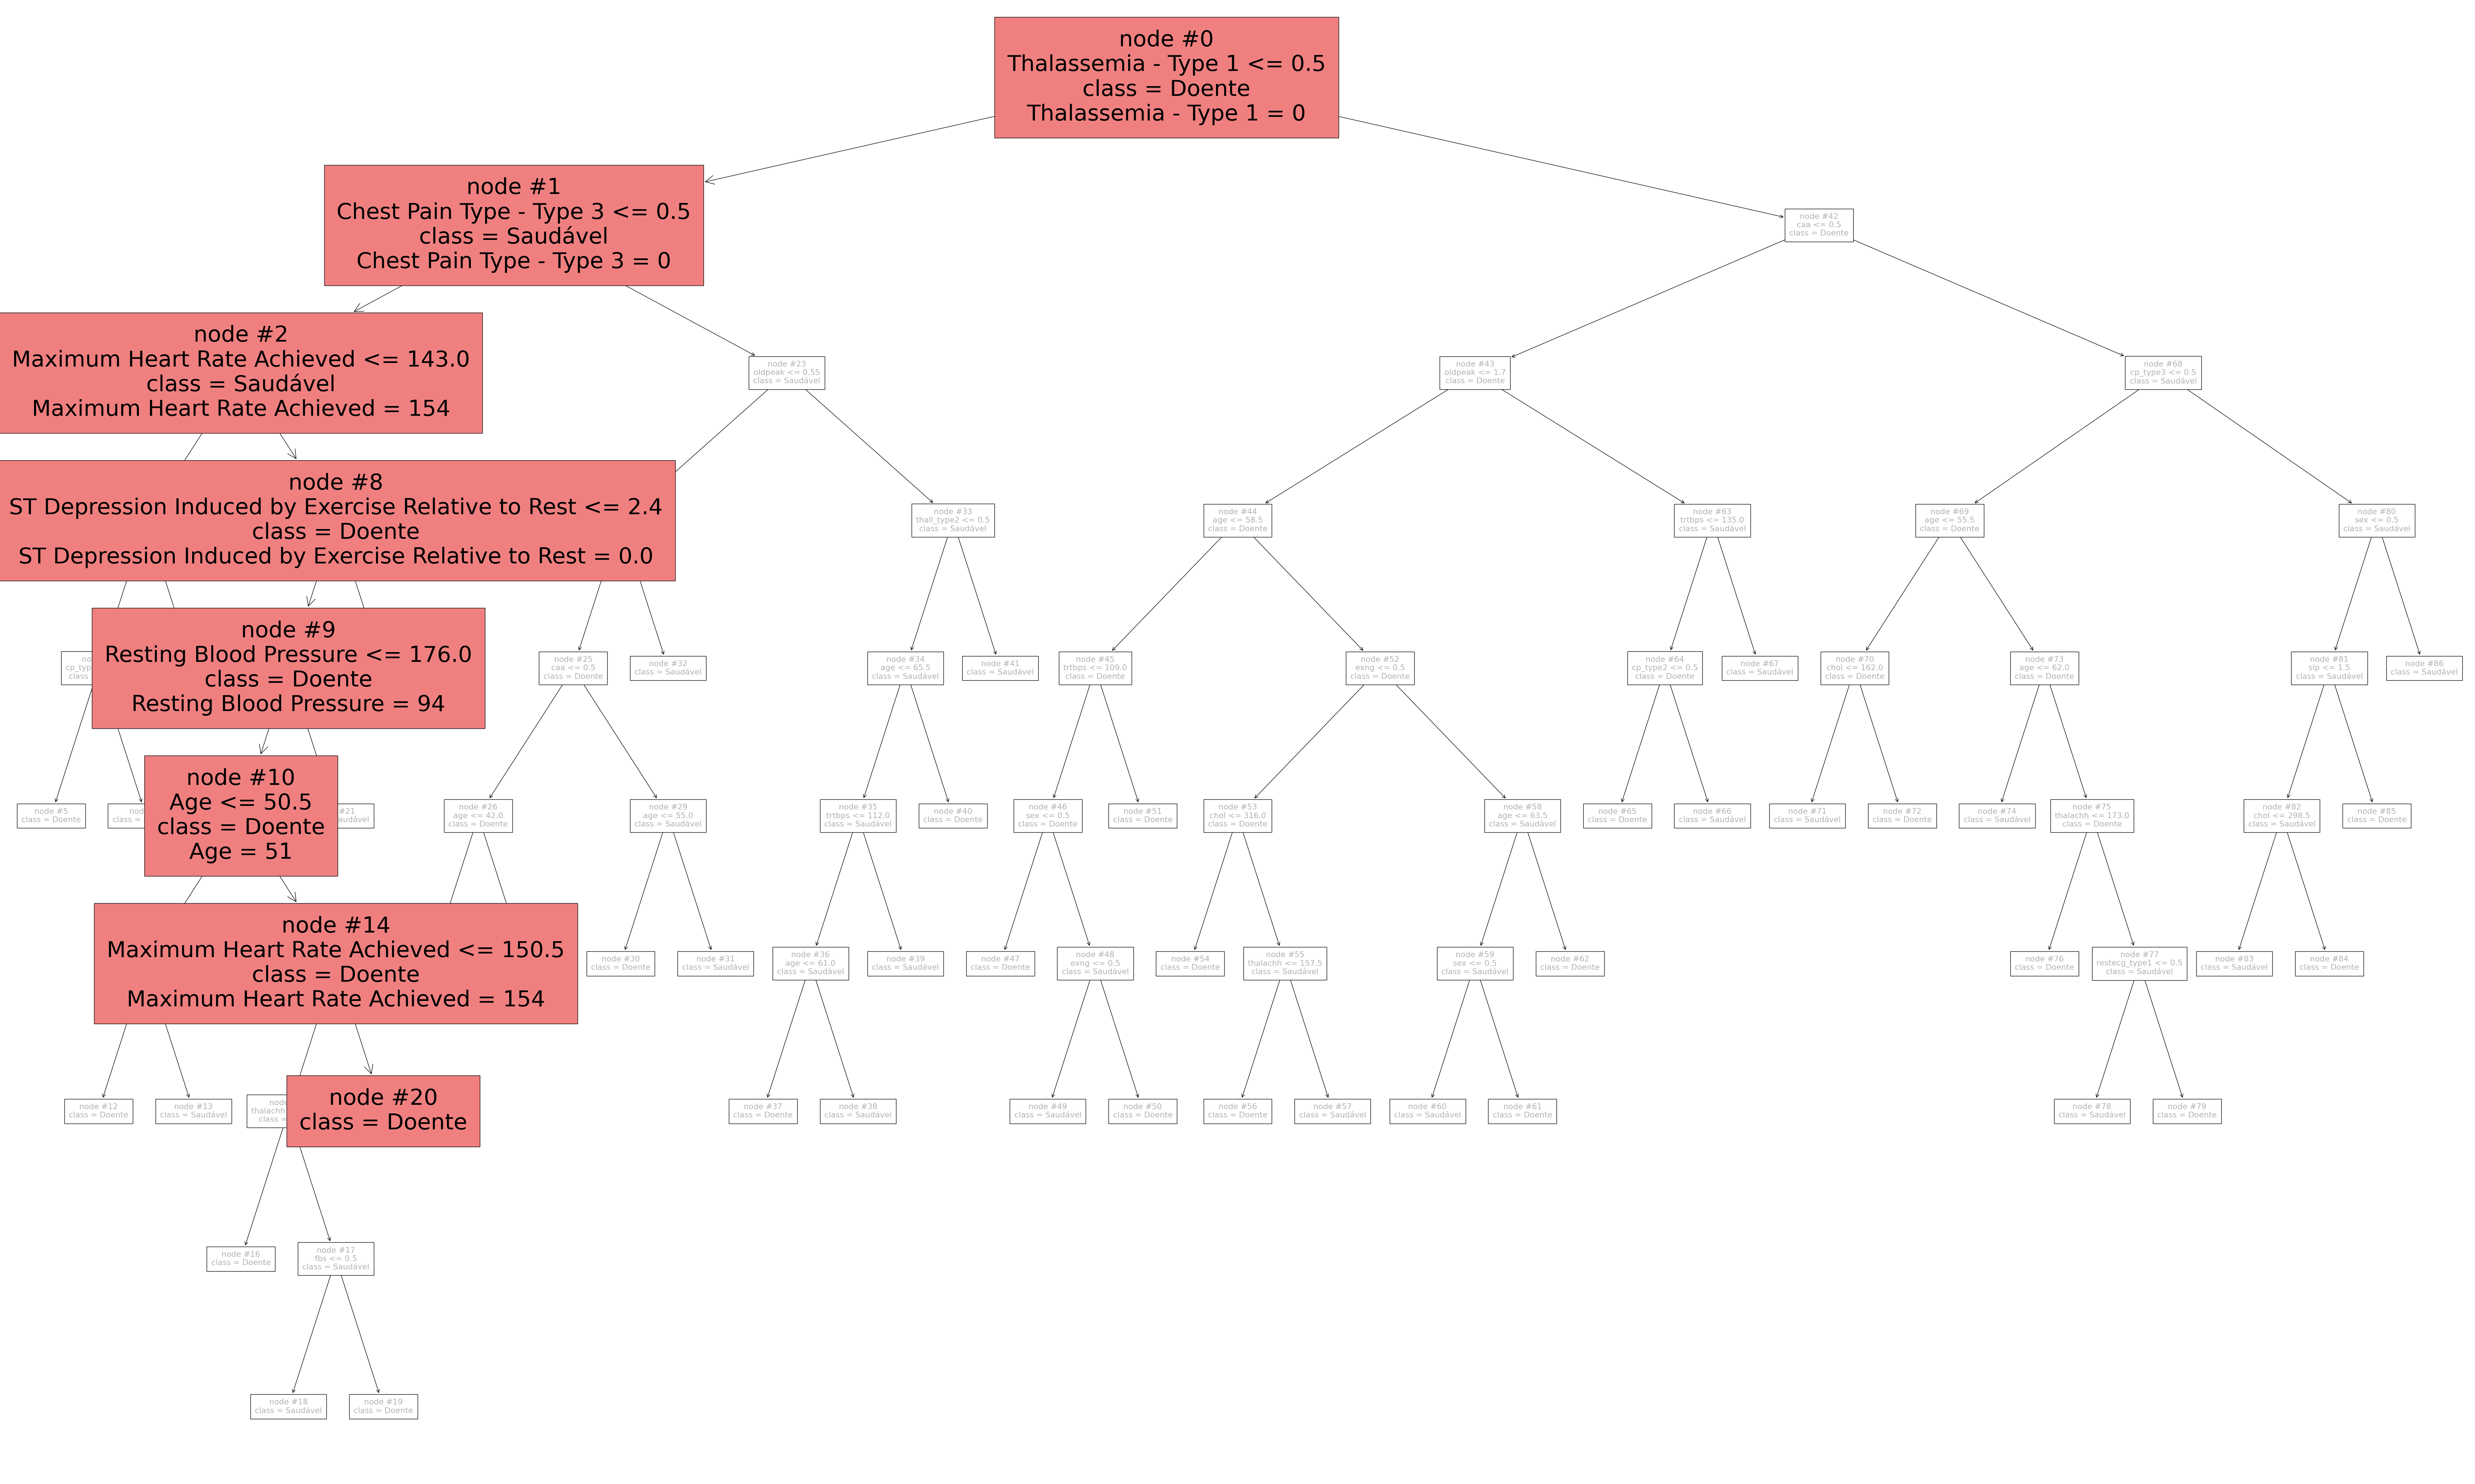

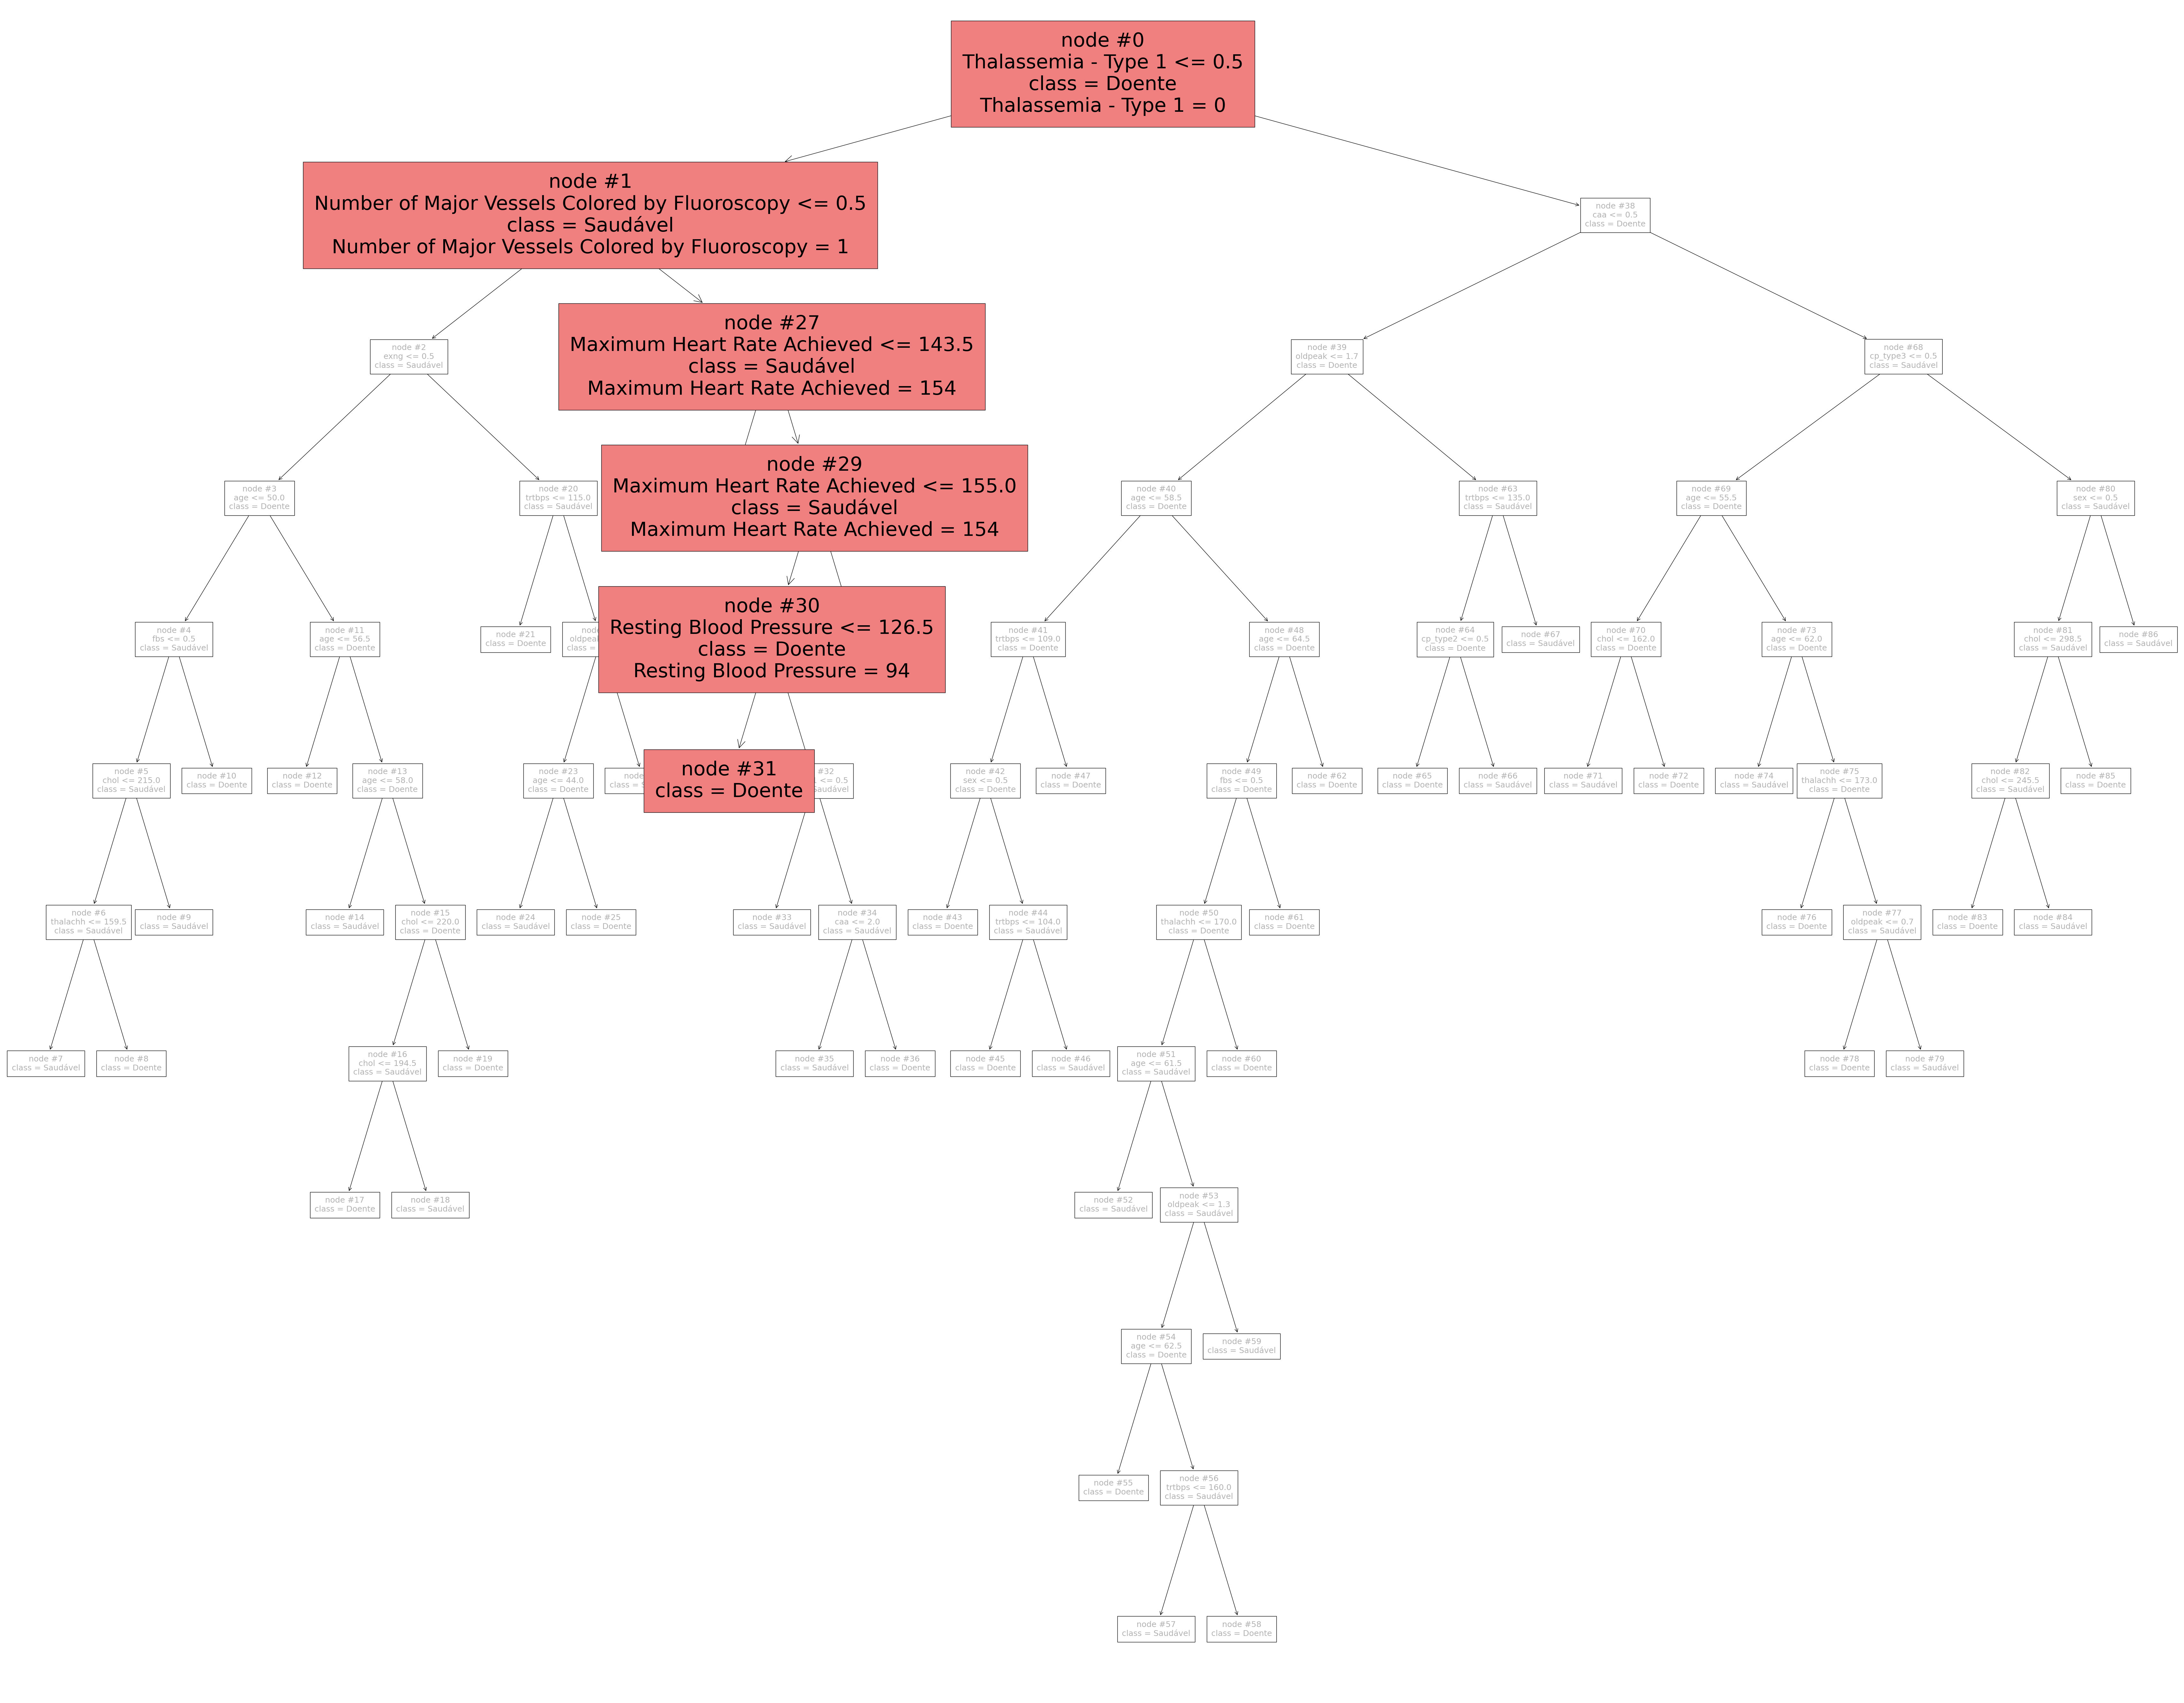

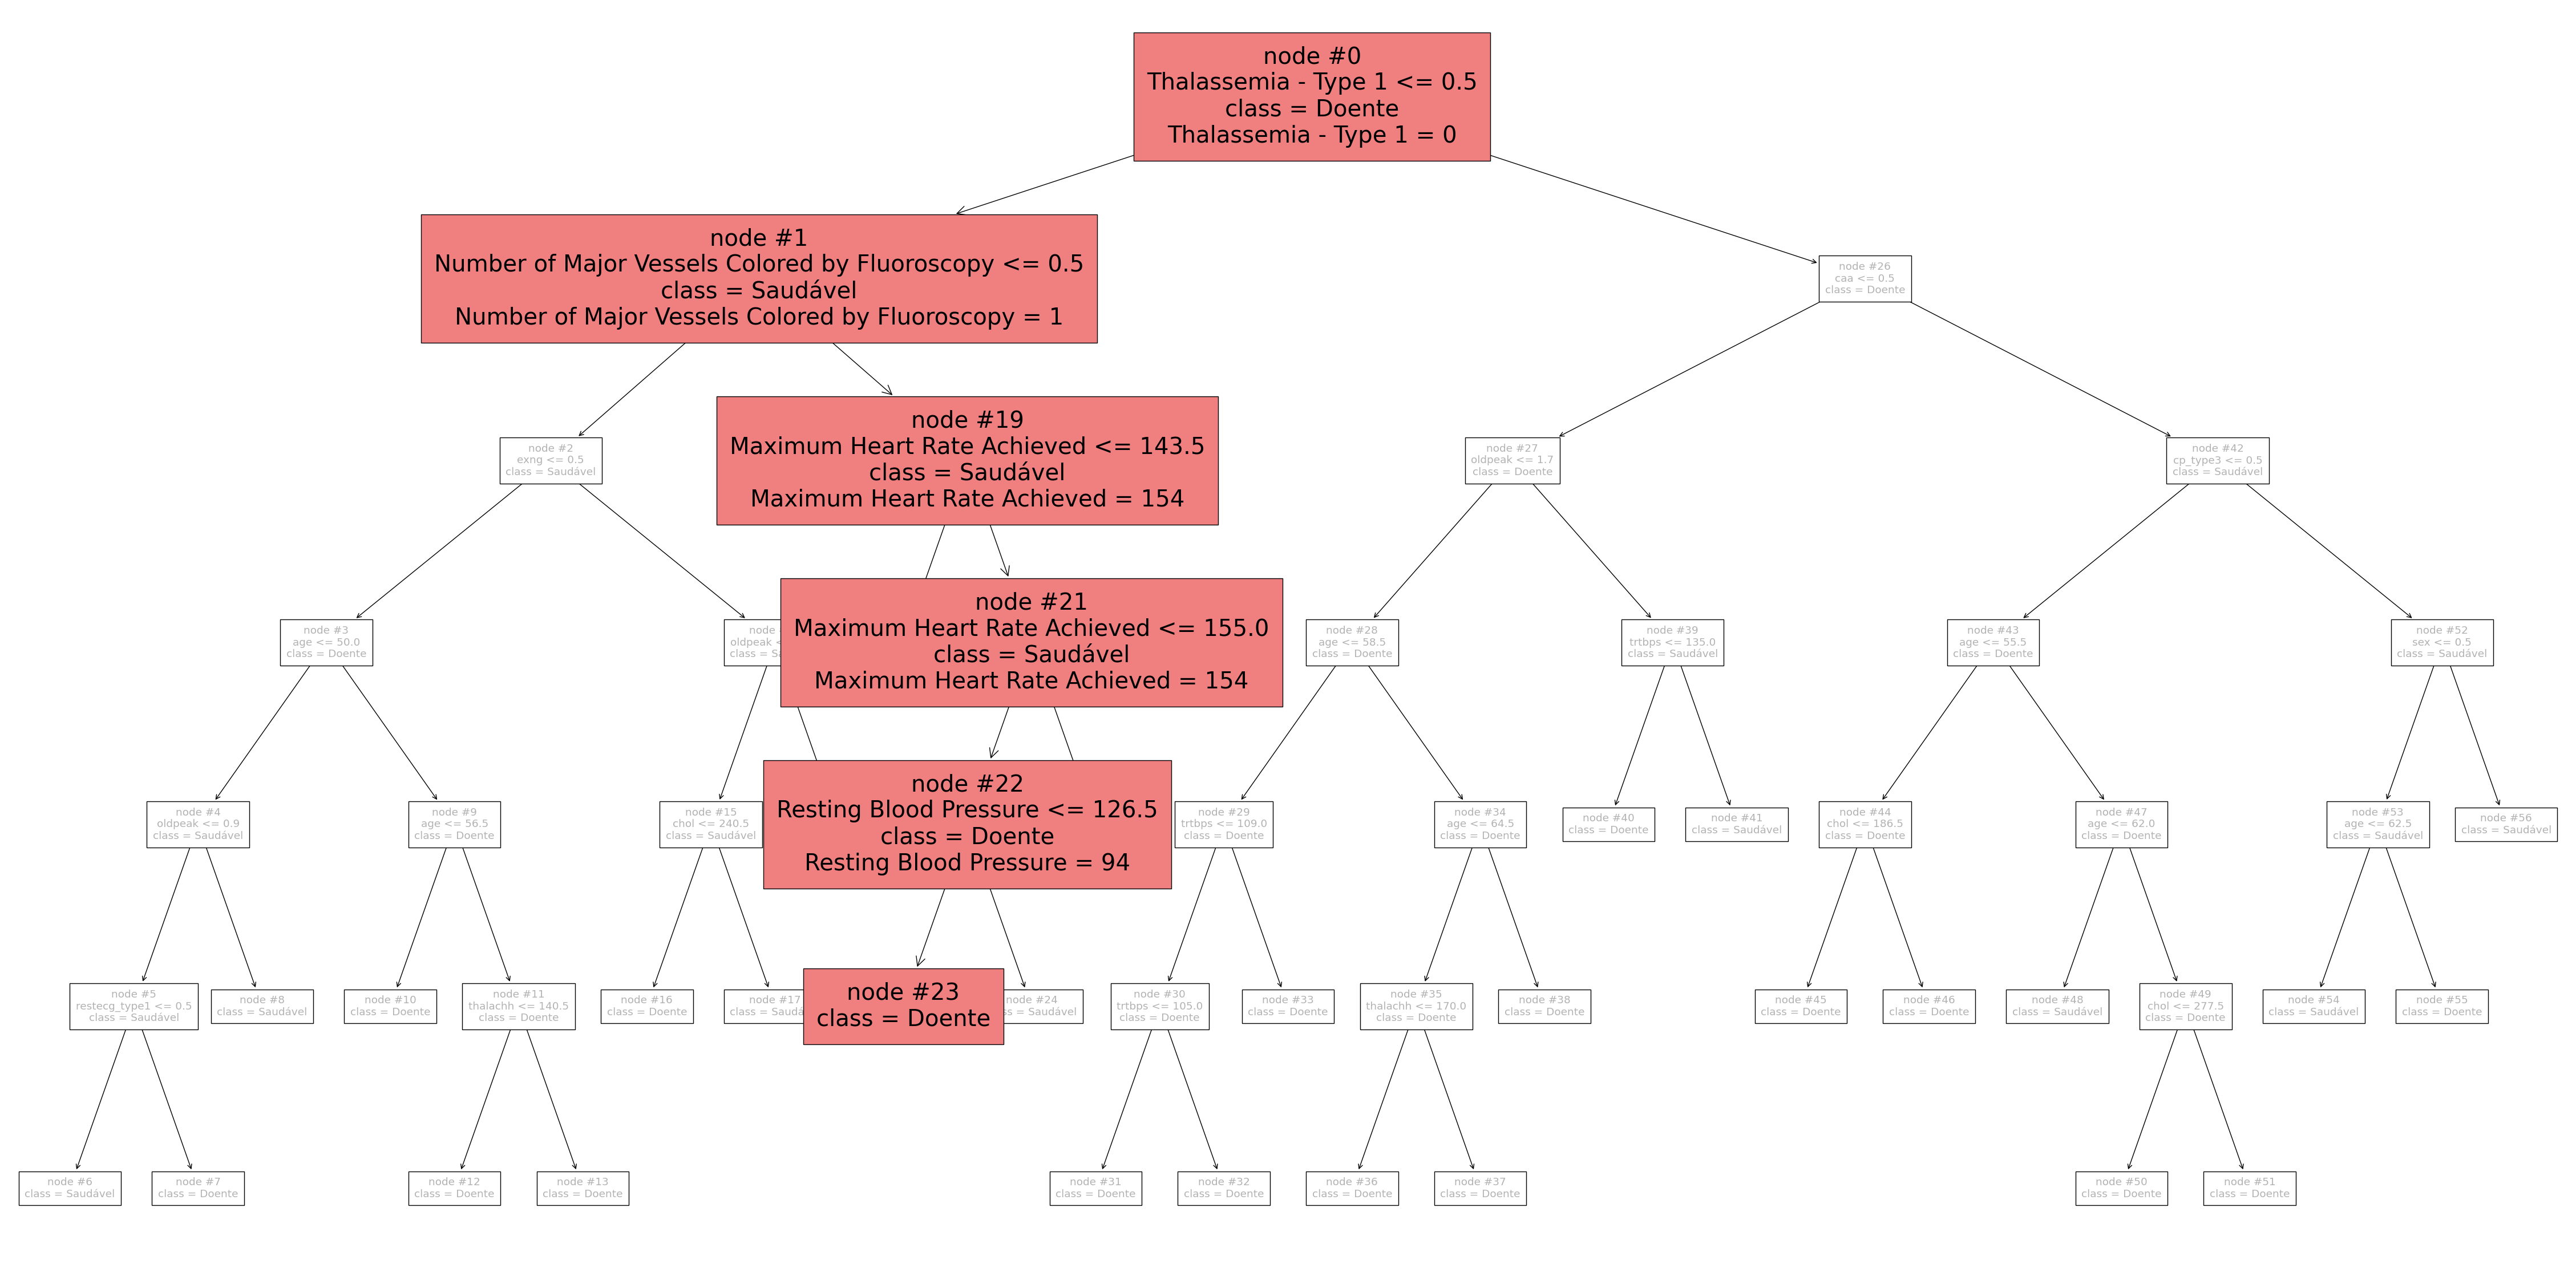

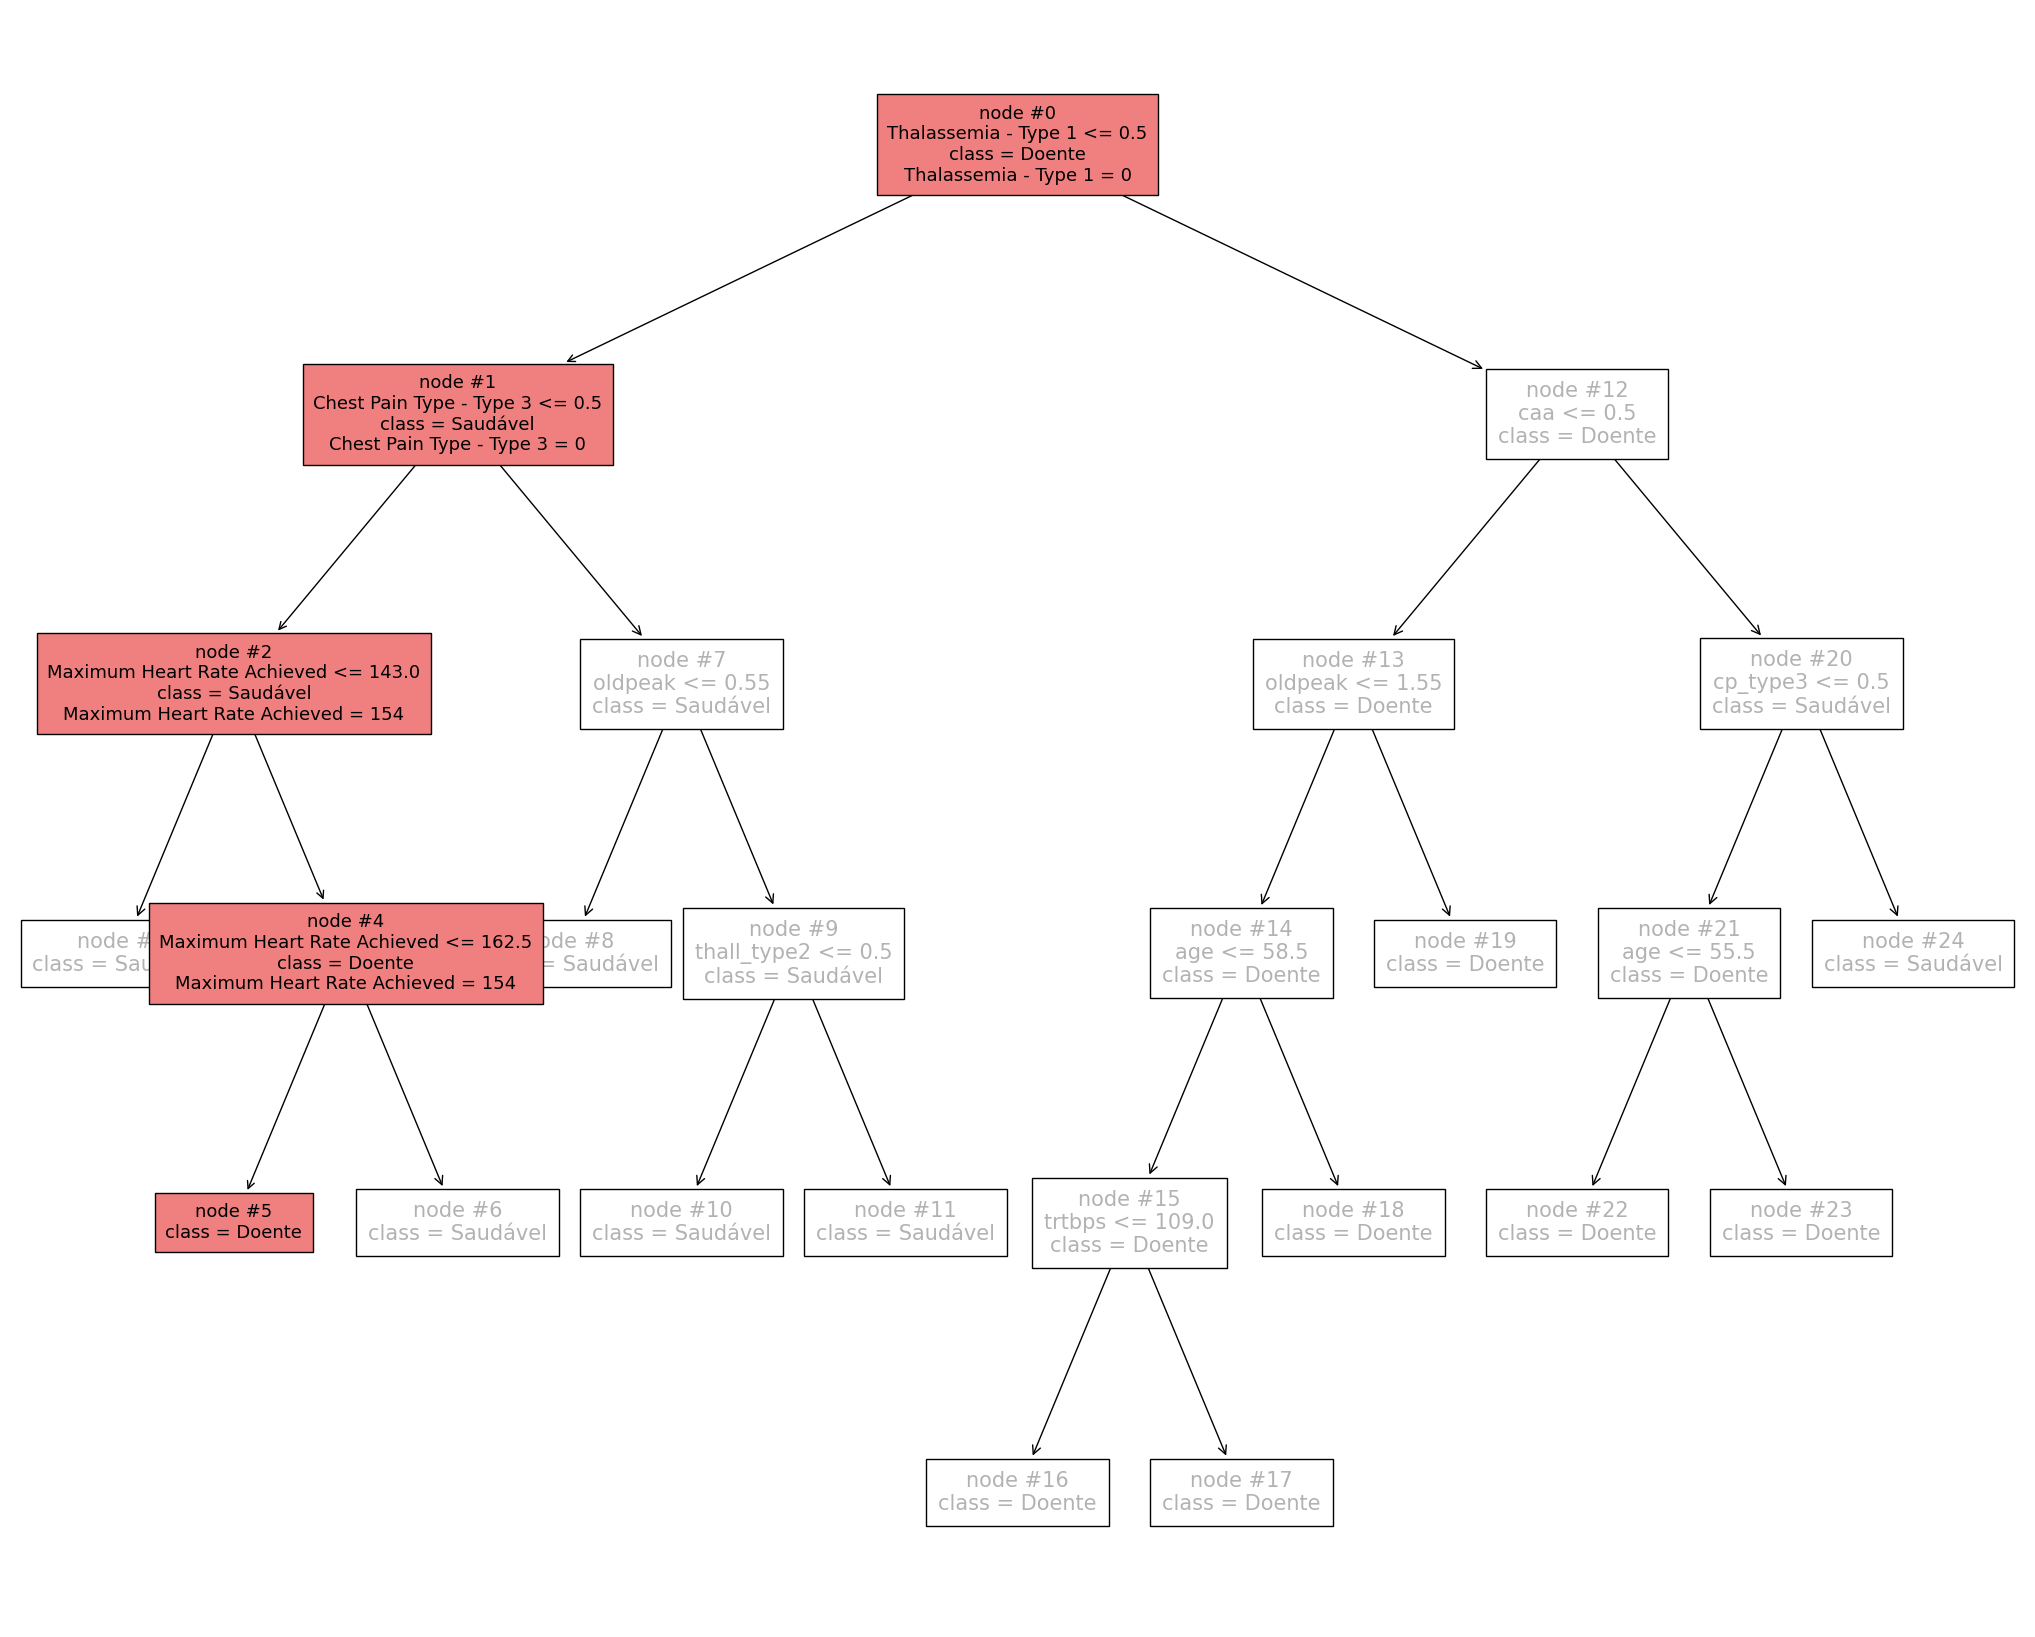

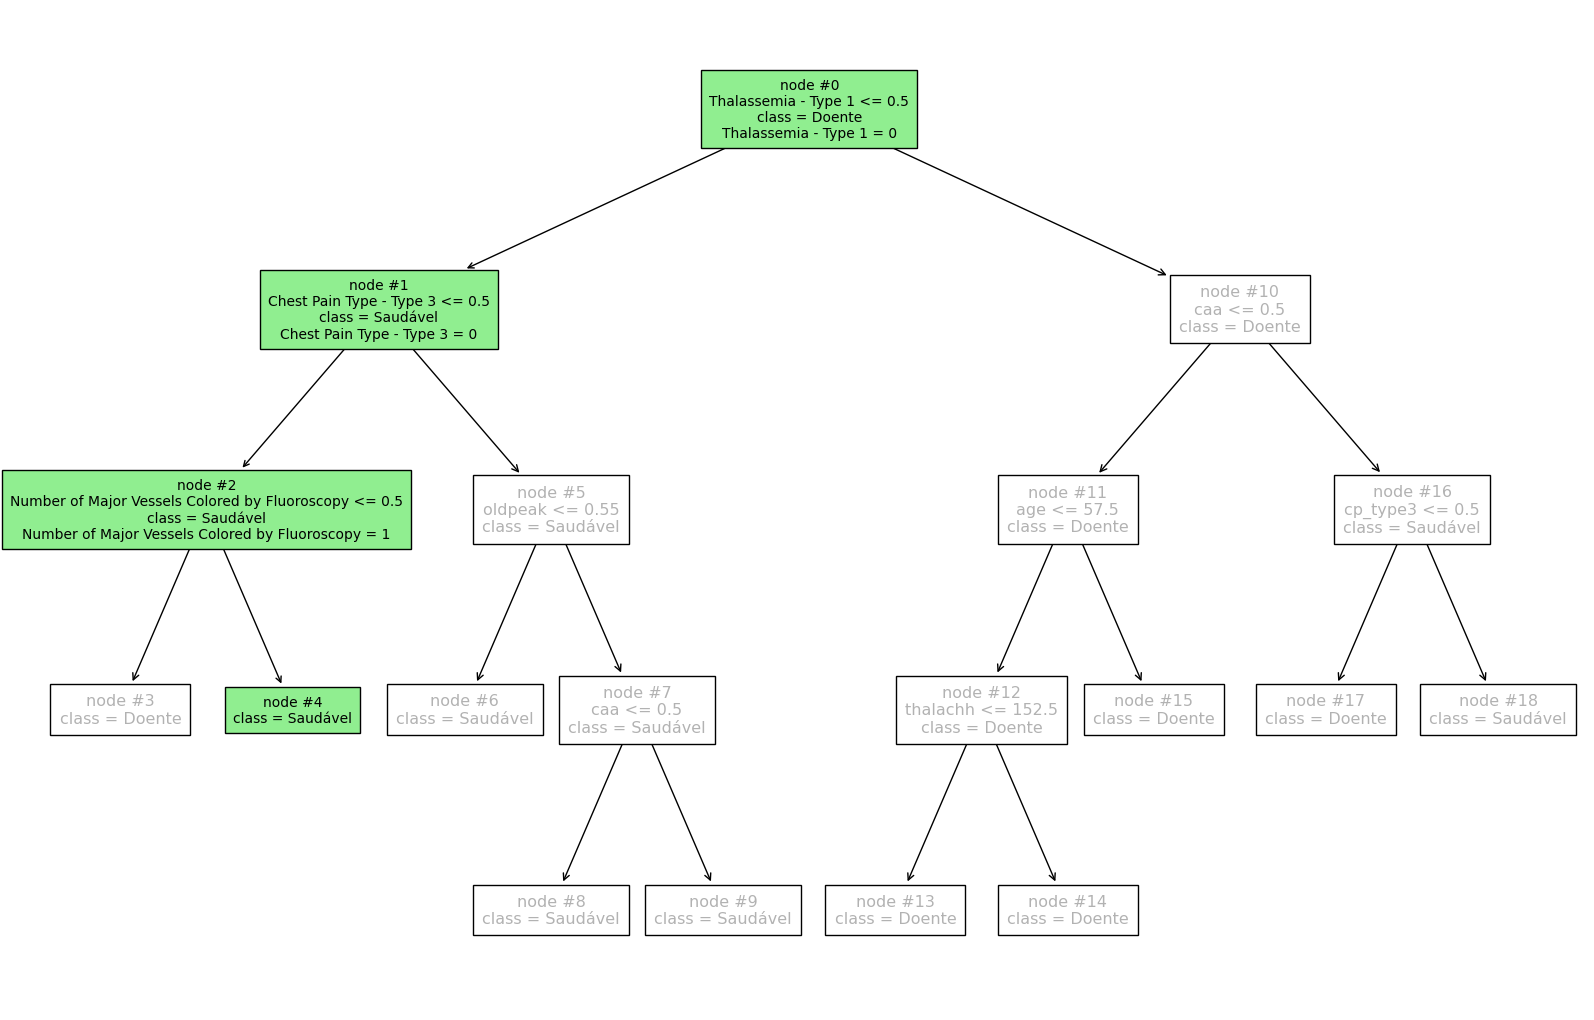

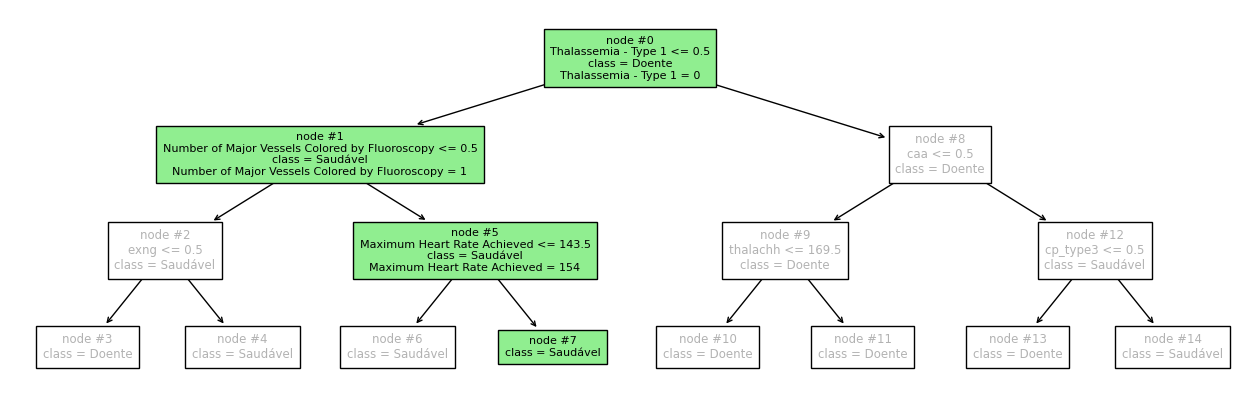

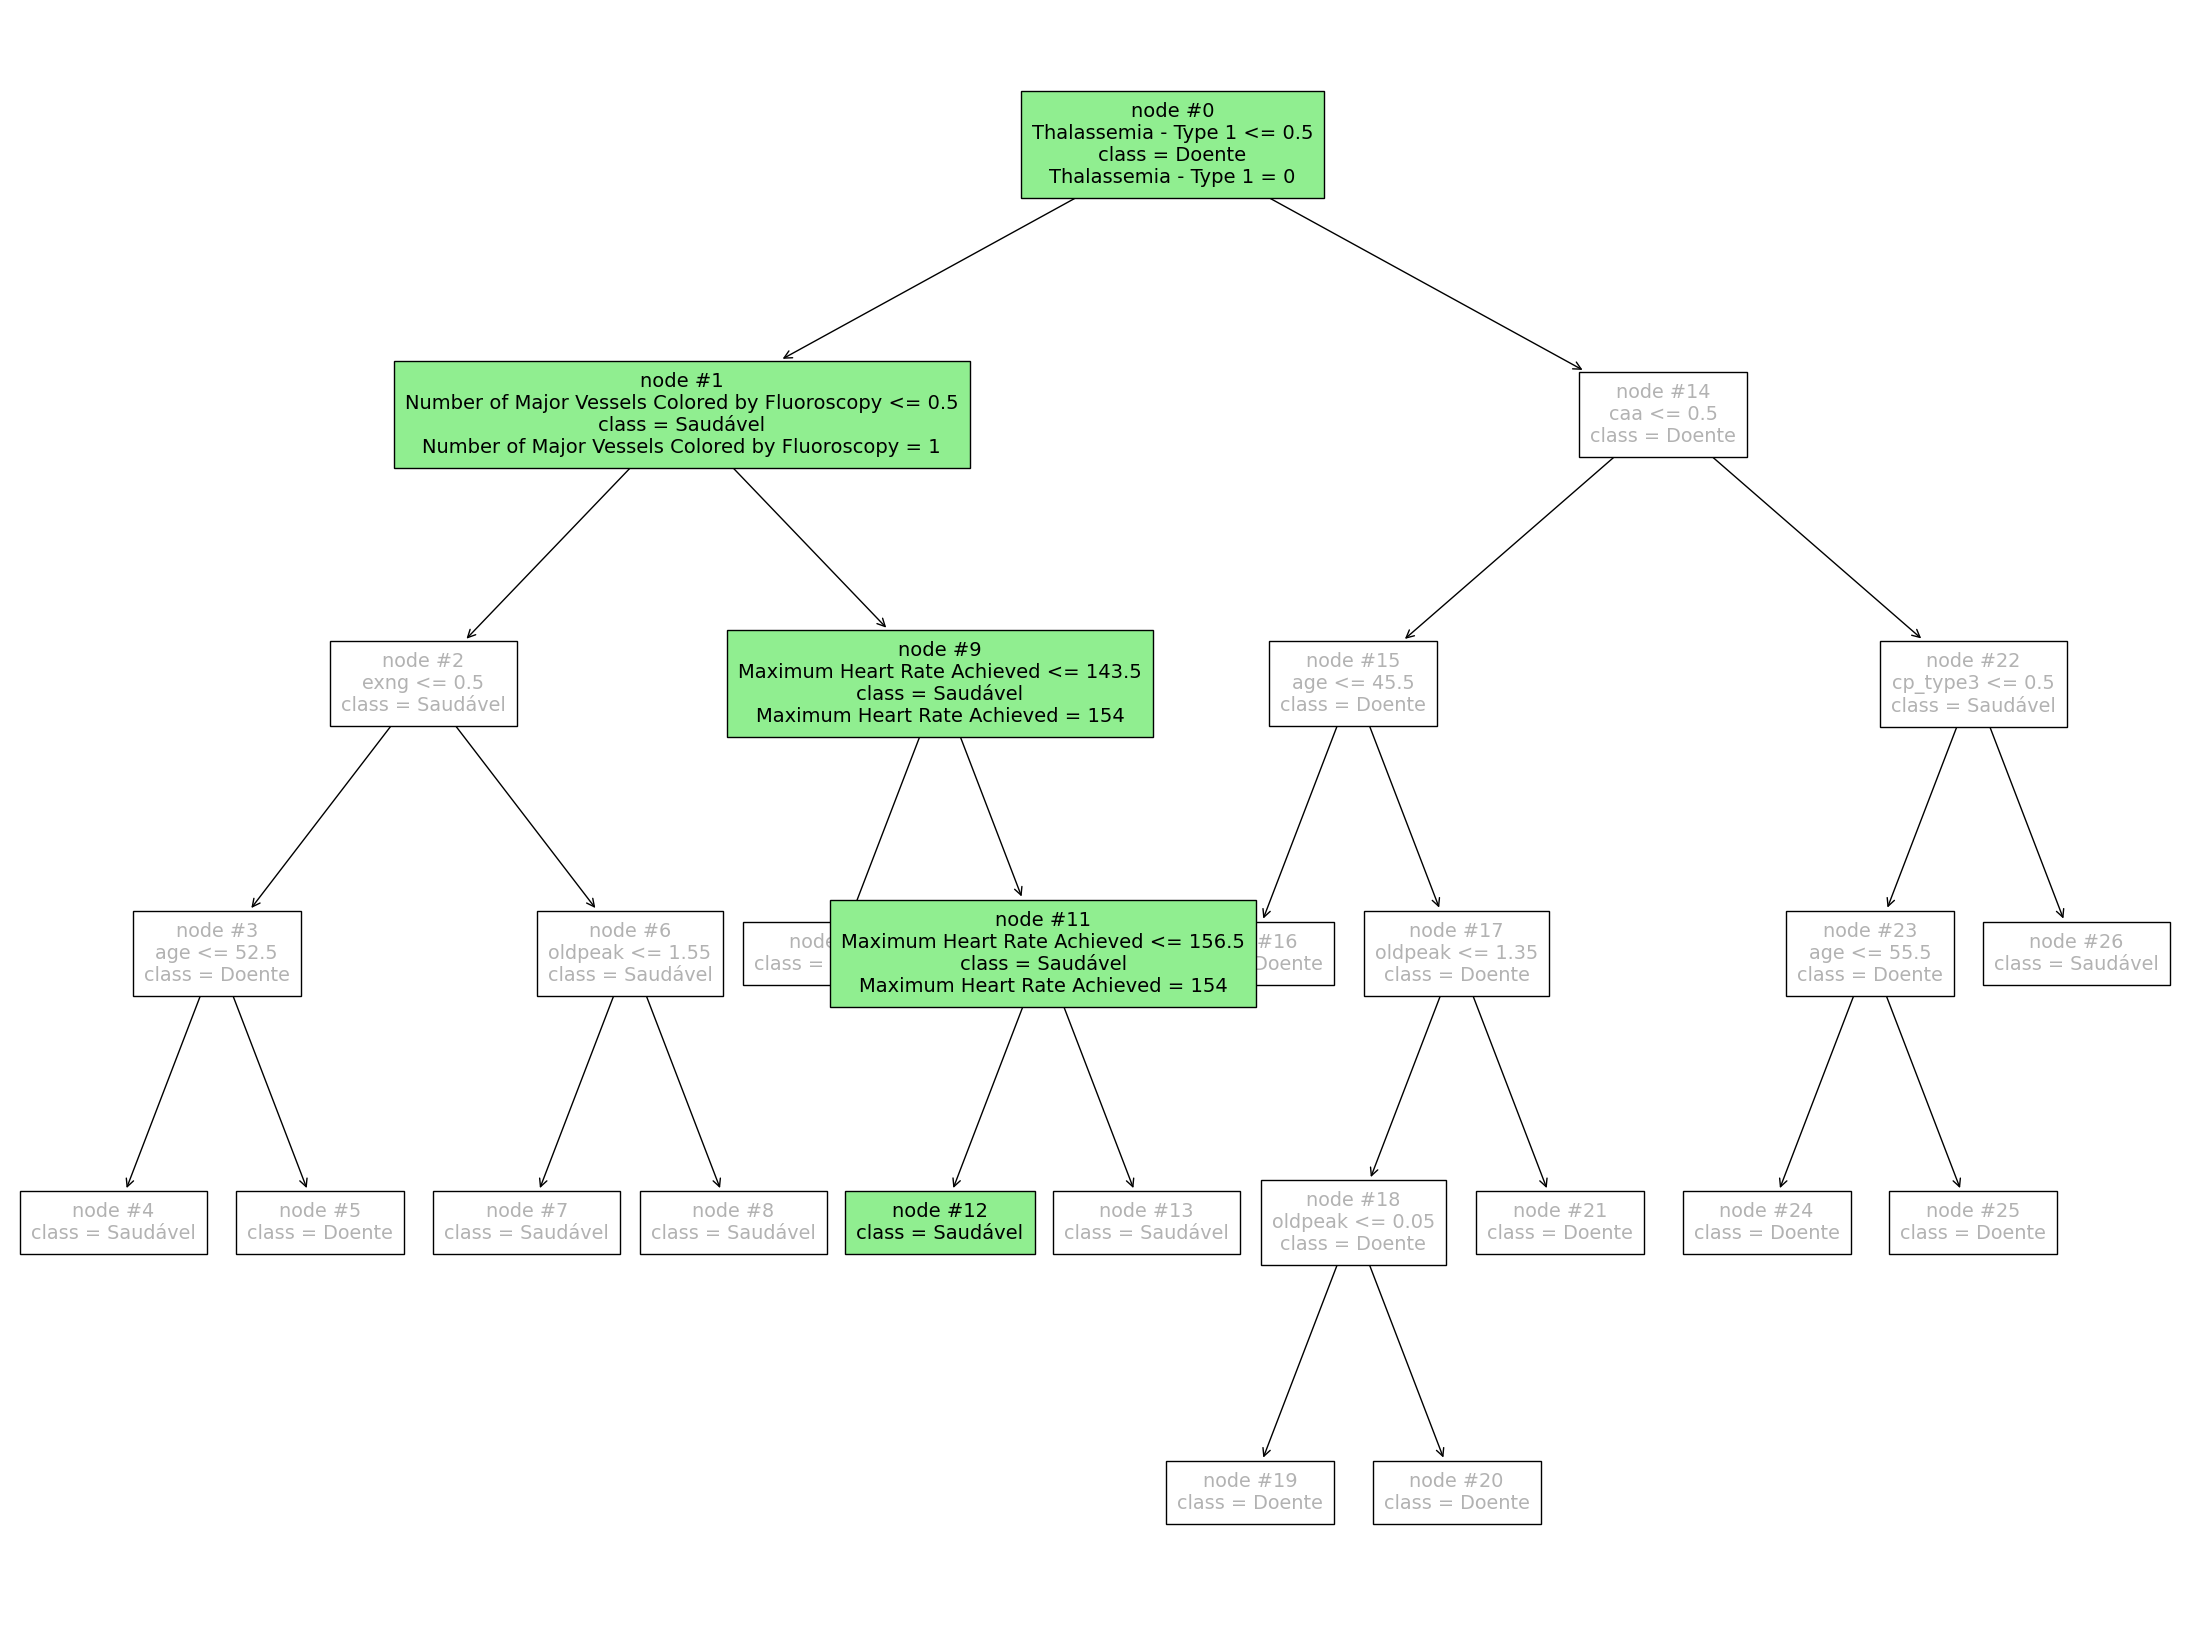

In [37]:
# Auditoria do Modelo
target = y[_index:_index+1]
_print_row(vt_classifier, row_analysis, target)

for estimator_ in vt_classifier.estimators_:
    plot_decision(estimator_, row_analysis)